In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
base_metadata_pth = Path('/home/tsakalis/ntua/nestor_celvia/metadata')

basic_metadata_file = 'metadata.repository.2024-11-05.json'
clinical_cohort_file = 'clinical.cohort.2024-11-07.json'
biospecimen_file = 'biospecimen.cohort.2024-11-07.json'
gene_expr_file = 'Human__TCGA_OV__UNC__RNAseq__GA_RNA__01_28_2016__BI__Gene__Firehose_RSEM_log2.cct'
# gene_expr_file = "Human__TCGA_OV__UNC__RNAseq__HiSeq_RNA__01_28_2016__BI__Gene__Firehose_RSEM_log2.cct"

gene_mutation_file = 'Human__TCGA_OV__WUSM__Mutation__GAIIx__01_28_2016__BI__Gene__Firehose_MutSig2CV.cbt'

In [4]:
gene_names = pd.read_csv(base_metadata_pth / 'GeneNames.tsv', header=None)

In [5]:
metadata_df = pd.read_json(base_metadata_pth / basic_metadata_file)

clinical_cohort_df = pd.read_json(base_metadata_pth / clinical_cohort_file)

biospecimen_df = pd.read_json(base_metadata_pth / biospecimen_file)
gene_expr_df = pd.read_csv(base_metadata_pth / gene_expr_file, delimiter='\t')

gene_mutation_df = pd.read_csv(base_metadata_pth / gene_mutation_file,
                               delimiter='\t')

In [6]:
latent_vec_pth = Path(
    '/Users/tsakalis/ntua/nestor/nestor_celvia/src/vae_embeddings/latent_vectors_individual'
)

In [7]:
import torch

In [8]:
latent_vec_pth = Path(
    '/home/tsakalis/ntua/nestor_celvia/latent_vectors_individual'
)
latent_vecs = [
    (pth.stem,
     torch.load(pth, map_location=torch.device('cpu')).numpy())
    for pth in latent_vec_pth.glob('*.pt')
]

# latent_vecs = [np.load(pth) for pth in latent_vec_pth.glob('*.npy')]

/tmp/ipykernel_47176/3201932841.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(pth, map_location=torch.device('cpu')).numpy())


In [32]:
import h5py
import pandas as pd


def load_h5(path, key='mean'):
    """
    Load data from an HDF5 file and return the specified dataset as a DataFrame.

    Parameters:
    - path (str): Path to the HDF5 file.
    - key (str): Key of the dataset to retrieve.

    Returns:
    - pd.DataFrame: DataFrame containing the data from the specified key.
    """
    with h5py.File(path, "r") as f:
        if key not in f:
            raise KeyError(f"Key '{key}' not found in the HDF5 file.")

        ds_arr = f[key][()]  # Get the numpy array from the specified key

    # Return the data as a DataFrame
    return pd.DataFrame(ds_arr)


In [33]:
latent_vec_pth = Path(
    '/home/tsakalis/ntua/nestor_celvia/vae_embeddings/embeddings_adco'
)
latent_vecs = [(pth.stem, load_h5(pth), load_h5(pth, key='max'),
                load_h5(pth, key='min'), load_h5(pth, key='std'))
               for pth in latent_vec_pth.glob('*.h5')]

In [55]:
all_latent_df = []

for latent in latent_vecs:
    latent_df_mean = pd.DataFrame(latent[1]).transpose()
    latent_df_max = pd.DataFrame(latent[2]).transpose()

    latent_df_min = pd.DataFrame(latent[3]).transpose()
    latent_df_std = pd.DataFrame(latent[4]).transpose()
    latent_df = pd.concat(
        [latent_df_mean, latent_df_max, latent_df_min, latent_df_std], axis=1)
    # break
    latent_df.columns = [f"emb_{i}" for i in range(4096)]
    latent_df['file_name'] = latent[0] + ".svs"  #.split('_')[0]
    # if test_id == latent[0]:
    #     break
    all_latent_df.append(latent_df)

In [56]:
latent_vec_pth = Path(
    '/Users/tsakalis/ntua/nestor/nestor_celvia/src/vae_embeddings/latent_vectors'
)

latent_vecs2 = [(pth.stem, np.load(pth))
                for pth in latent_vec_pth.glob('*.npy')]

# latent_vecs = [np.load(pth) for pth in latent_vec_pth.glob('*.npy')]

In [57]:
metadata_df['submitter_id'] = metadata_df.submitter_id.apply(
    lambda x: '.'.join(x.split('-')[:3]))

In [58]:
merged_genes = pd.merge(gene_expr_df.set_index('attrib_name'),
                        gene_names,
                        left_index=True,
                        right_on=0)


In [59]:
clinical_cohort_df['submitter_id'] = clinical_cohort_df['submitter_id'].apply(
    lambda x: x.replace('-', '.'))

In [60]:
gene_patient = pd.merge(metadata_df,
                        merged_genes.T,
                        left_on='submitter_id',
                        right_index=True)

In [62]:
metadata_latent = pd.merge(metadata_df,
                           pd.concat(all_latent_df),
                           on='file_name')

In [63]:
all_data = pd.merge(metadata_latent,
                    gene_patient.reset_index(drop=True),
                    on='file_id',
                    how='inner')

In [64]:
# Get unique values of the stratify column
from sklearn.model_selection import train_test_split

unique_values = all_data['submitter_id_x'].unique()

# Split unique values into train and test
train_ids, test_ids = train_test_split(all_data.index,
                                       test_size=0.2,
                                       random_state=42)

In [65]:
train_data = all_data.loc[train_ids]
test_data = all_data.loc[test_ids]

In [66]:
target_labels = all_data.columns[-35:]

In [67]:
genes_ovarian_cancer = [
    "BRCA1", "BRCA2", "TP53", "RAD51C", "RAD51D", "PALB2", "ATM", "CHEK2",
    "PTEN", "ARID1A"
]


In [68]:
input_labels = [f"emb_{i}" for i in range(1024)]

In [69]:
from sklearn.preprocessing import LabelEncoder

encode_p = LabelEncoder().fit_transform(all_data['submitter_id_x'])

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, accuracy_score, f1_score, classification_report, r2_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

In [71]:
pca = PCA(n_components=2)

pcaed = pca.fit_transform(all_data[input_labels])

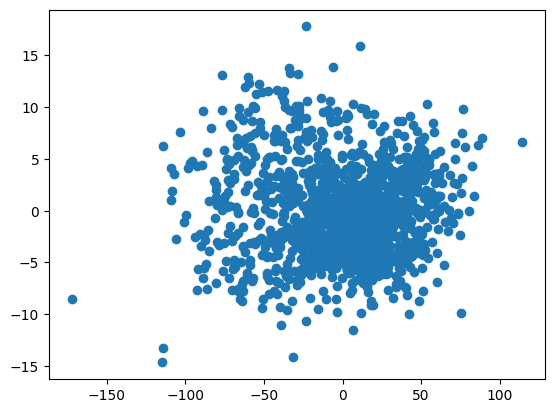

In [72]:
plt.scatter(pcaed[:,0], pcaed[:,1])

In [73]:
X_train, X_test, y_train, y_test = train_data[input_labels], test_data[
    input_labels], train_data[target_labels], test_data[target_labels]

In [74]:


for label in target_labels:
    model = LGBMRegressor(n_jobs=-1, n_estimators=100, learning_rate=0.001)
    model.fit(X_train, np.log(y_train[label].astype(float)+1))

    # Make predictions
    y_pred = model.predict(X_test)
    # print(mean_squared_error(y_test.flatten(), y_pred.flatten()))
    print(r2_score(np.log(y_test[label].astype(float)+1), y_pred))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258589
[LightGBM] [Info] Number of data points in the train set: 1067, number of used features: 1017
[LightGBM] [Info] Start training from score 2.088675
0.02005496830686837
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258589
[LightGBM] [Info] Number of data points in the train set: 1067, number of used features: 1017
[LightGBM] [Info] Start training from score 1.825761
0.020009351571483758
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258589
[LightG

In [171]:
X_train.shape

(26846, 1024)

In [75]:
import lightgbm as lgb
from sklearn.metrics import r2_score

for label in target_labels:
    # Prepare LightGBM datasets
    train_data = lgb.Dataset(X_train, label=np.log(y_train[label].astype(float)))
    test_data = lgb.Dataset(X_test, label=np.log(y_test[label].astype(float)), reference=train_data)
    
    # Set LightGBM parameters
    params = {
        'objective': 'regression',
        'metric': 'rmse',  # Use RMSE or any relevant regression metric
        'learning_rate': 0.001,
        'num_threads': -1,
        'verbosity': -1,
        'lambda_l1': 0.0,
        'lambda_l2': 0.0,
        # 'num_leaves': 1024, # Larger than typical values
        'min_data_in_leaf': 1

    }
    
    # Train the model
    model = lgb.train(
        params,
        train_data,
        num_boost_round=500,  # Equivalent to n_estimators
        valid_sets=[train_data, test_data],
        valid_names=['train', 'test'],
        # verbose_eval=False
    )
    
    # Make predictions
    y_pred = model.predict(X_test)
    print(np.corrcoef(np.log(y_test[label].astype(float)), y_pred))
    


[[1.        0.3037047]
 [0.3037047 1.       ]]
[[1.         0.23283844]
 [0.23283844 1.        ]]
[[1.        0.2384287]
 [0.2384287 1.       ]]
[[1.        0.1353745]
 [0.1353745 1.       ]]
[[1.         0.03568896]
 [0.03568896 1.        ]]
[[1.         0.18484929]
 [0.18484929 1.        ]]
[[1.        0.2974058]
 [0.2974058 1.       ]]
[[1.         0.06333557]
 [0.06333557 1.        ]]
[[1.         0.08558767]
 [0.08558767 1.        ]]
[[1.         0.36133962]
 [0.36133962 1.        ]]
[[1.         0.13524648]
 [0.13524648 1.        ]]
[[1.         0.26380507]
 [0.26380507 1.        ]]
[[1.         0.21176456]
 [0.21176456 1.        ]]
[[1.         0.00904105]
 [0.00904105 1.        ]]
[[1.         0.07144169]
 [0.07144169 1.        ]]
[[1.         0.13079487]
 [0.13079487 1.        ]]
[[1.         0.41093643]
 [0.41093643 1.        ]]
[[1.         0.29633913]
 [0.29633913 1.        ]]
[[1.         0.06346754]
 [0.06346754 1.        ]]
[[1.         0.03870539]
 [0.03870539 1.       

In [ ]:
for i in range(len(target_labels)):
    print(
        np.corrcoef(y_test.values[:, i].flatten().astype(float),
                    y_pred[:, i].flatten()))

In [ ]:
plt.scatter(y_test.values[:, 10].flatten(), y_pred[:, 10].flatten())

In [ ]:
plt.scatter(y_test.values.flatten(), y_pred.flatten())

In [ ]:
for i in range(len(target_labels)):
    model = RandomForestRegressor()
    model.fit(X_train, y_train[:, i])

    # Make predictions
    y_pred = model.predict(X_test)
    # print(mean_squared_error(y_test.flatten(), y_pred.flatten()))
    print(r2_score(y_test[:, i], y_pred))

In [ ]:
def find_vector_duplicates(array1, array2):
    # Convert each vector to a tuple for hashable comparison
    set1 = {tuple(vec) for vec in array1}
    duplicates = [vec for vec in array2 if tuple(vec) in set1]
    return duplicates

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

In [ ]:
scaler = MinMaxScaler()
X_scaled = pca.fit_transform(X)


In [ ]:
pcaed = pca.fit_transform(X)

In [ ]:
X_train

In [ ]:
plt.scatter(pcaed[:, 0], pcaed[:, 1])
plt.xlim(-0.445, -0.46)
plt.ylim(-0.05, 0.05)


In [ ]:
correls = []
folds = KFold(5, shuffle=False)

for train_idx, test_idx in folds.split(X, y):

    X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[
        train_idx], y[test_idx]
    # Use Random Forest Regressor
    model = RandomForestRegressor(n_estimators=10, n_jobs=-1)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    print(mean_squared_error(y_test.flatten(), y_pred.flatten()))
    print(r2_score(y_test, y_pred))
    # correls.append(np.corrcoef(y_test, y_pred)[0, 1])

    # plt.scatter(y_test.flatten(), y_pred.flatten(), s=0.5)

In [ ]:
correls = []
for i in range(len(target_labels)):
    correls.append(np.corrcoef(y_test[:, i], y_pred[:, i])[0, 1])

In [ ]:
np.sort(np.abs(correls))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data extracted from the plot (example data, replace with actual values)
sort_idx = np.argsort(np.abs(correls))[::-1]
genes = np.array(target_labels)[sort_idx[:112]]

# Plotting
y_pos = np.arange(len(genes))

plt.figure(figsize=(10, 8))
plt.barh(y_pos - 0.2,
         np.abs(correls)[sort_idx[:112]],
         height=0.4,
         label='Pearson',
         color='blue',
         alpha=0.7)
# plt.barh(y_pos + 0.2, spearman, height=0.4, label='Spearman', color='orange', alpha=0.7)

plt.yticks(y_pos, genes)
plt.xlabel("Correlation Coefficient")
plt.title("Correlation Comparison (Pearson vs Spearman)")
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend()
plt.tight_layout()

plt.show()


In [ ]:
y_test.shape

In [ ]:
np.corrcoef(y_test.T, y_pred.T)

In [ ]:
pca_vecs = pca.fit_transform(latent_vecs)

In [ ]:
pca.explained_variance_ratio_.sum()

In [ ]:
pca.get_covariance()

In [ ]:
np.corrcoef(pca_vecs[:, 0], [pca_vecs[:, 1]])

In [ ]:
plt.scatter(pca_vecs[:, 0], [pca_vecs[:, 1]])
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)